In [ ]:
import requests

import requests
import pandas as pd

In [1]:
url = "https://data.ibb.gov.tr/api/3/action/datastore_search"
params = {
    "resource_id": "ba47eacb-a4e1-441c-ae51-0e622d4a18e2",
    "q": "2023",
    "limit": 365
}

response = requests.get(url, params=params)
data = response.json()

records = data["result"]["records"]

# alt alta yazdır
for r in records:
    print(f"{r['trafficindexdate']} ------ {r['average_traffic_index']}")



2023-01-01T03:00:00 ------ 16.927083333333332
2023-01-02T03:00:00 ------ 26.003460207612456
2023-01-03T03:00:00 ------ 31.372822299651567
2023-01-04T03:00:00 ------ 31.97508896797153
2023-01-05T03:00:00 ------ 31.25
2023-01-06T03:00:00 ------ 32.53125
2023-01-07T03:00:00 ------ 27.4375
2023-01-08T03:00:00 ------ 16.75
2023-01-09T03:00:00 ------ 29.256944444444443
2023-01-10T03:00:00 ------ 31.53472222222222
2023-01-11T03:00:00 ------ 35.94444444444444
2023-01-12T03:00:00 ------ 34.982638888888886
2023-01-13T03:00:00 ------ 39.548611111111114
2023-01-14T03:00:00 ------ 26.024305555555557
2023-01-15T03:00:00 ------ 14.409722222222221
2023-01-16T03:00:00 ------ 28.180555555555557
2023-01-17T03:00:00 ------ 33.11805555555556
2023-01-18T03:00:00 ------ 33.53472222222222
2023-01-19T03:00:00 ------ 34.173611111111114
2023-01-20T03:00:00 ------ 36.52982456140351
2023-01-21T03:00:00 ------ 31.72222222222222
2023-01-22T03:00:00 ------ 20.901818181818182
2023-01-23T03:00:00 ------ 31.142361111111

In [9]:
# Istanbul coordinates
LAT = 41.0082
LON = 28.9784

YEAR = 2023
START_DATE = f"{YEAR}-01-01"
END_DATE = f"{YEAR}-12-31"

OUTPUT_CSV = f"istanbul_daily_weather_{YEAR}_openmeteo.csv"

def main():
    url = "https://archive-api.open-meteo.com/v1/archive"

    params = {
        "latitude": LAT,
        "longitude": LON,
        "start_date": START_DATE,
        "end_date": END_DATE,
        # only the variables you want
        "daily": ",".join([
            "temperature_2m_mean",
            "precipitation_sum"
        ]),
        "timezone": "Europe/Istanbul"
    }

    print("Requesting data from Open-Meteo...")
    response = requests.get(url, params=params)
    response.raise_for_status()

    data = response.json()

    daily = data.get("daily", {})
    if not daily:
        print("No 'daily' data found in response!")
        return

    df = pd.DataFrame(daily)

    # rename columns
    df = df.rename(columns={
        "time": "date",
        "temperature_2m_mean": "temp_avg",
        "precipitation_sum": "precipitation"
    })

    df.to_csv(OUTPUT_CSV, index=False)
    print(f"Saved {len(df)} daily records to {OUTPUT_CSV}")

    df["date"] = pd.to_datetime(df["date"])

    turkish_holidays_2023 = [
        "2023-01-01",  # New Year
        "2023-04-20",  # Ramadan Feast Eve (half day)
        "2023-04-21",  # Ramadan Feast 1
        "2023-04-22",  # Ramadan Feast 2
        "2023-04-23",  # Ramadan Feast 3 + 23 Nisan
        "2023-05-01",  # Labor and Solidarity Day
        "2023-05-19",  # Youth and Sports Day
        "2023-06-26",  # Kurban Bayram administrative holiday
        "2023-06-27",  # Kurban Feast Eve (half day)
        "2023-06-28",  # Kurban Feast 1
        "2023-06-29",  # Kurban Feast 2
        "2023-06-30",  # Kurban Feast 3
        "2023-07-01",  # Kurban Feast 4
        "2023-07-15",  # Democracy and National Unity Day
        "2023-08-30",  # Victory Day
        "2023-10-28",  # Republic Day Eve (half day)
        "2023-10-29",  # Republic Day
    ]

    holiday_dates = pd.to_datetime(turkish_holidays_2023)

    # weekend: Saturday (5) or Sunday (6)
    is_weekend = df["date"].dt.weekday >= 5
    is_holiday = df["date"].isin(holiday_dates)

    # 1.0 = working day, 0.0 = weekend or holiday
    df["is_workday"] = (~(is_weekend | is_holiday)).astype(float)

        # --- MERGE WEATHER + TRAFFIC INDEX AND SAVE FINAL DATASET ---

    # traffic records already fetched at the top as `records`
    traffic_df = pd.DataFrame(records)

    # parse date from traffic dataset
    traffic_df["date"] = pd.to_datetime(traffic_df["trafficindexdate"]).dt.date

    # make sure traffic index is numeric
    traffic_df["average_traffic_index"] = pd.to_numeric(
        traffic_df["average_traffic_index"], errors="coerce"
    )

    # keep only what we need and drop duplicate dates
    traffic_df = (
        traffic_df[["date", "average_traffic_index"]]
        .drop_duplicates(subset="date")
        .sort_values("date")
    )

    # make weather dates plain date (not datetime64)
    df["date"] = df["date"].dt.date

    # inner join → only days present in both datasets
    merged = pd.merge(df, traffic_df, on="date", how="inner")

    # save final dataset
    merged.to_csv("istanbul_traffic_weather_2023.csv", index=False)
    print(f"Saved merged dataset with {len(merged)} rows to istanbul_traffic_weather_2023.csv")


if __name__ == "__main__":
    main()


Requesting data from Open-Meteo...
Saved 365 daily records to istanbul_daily_weather_2023_openmeteo.csv
Saved merged dataset with 365 rows to istanbul_traffic_weather_2023.csv


In [10]:
import pandas as pd

df = pd.read_csv("istanbul_traffic_weather_2023.csv")

print("Head:")
print(df.head())

print("\nInfo:")
print(df.info())

print("\nDescribe (numeric):")
print(df.describe())

print("\nMissing values:")
print(df.isna().sum())

print("\nCorrelation matrix:")
print(df.corr(numeric_only=True))


Head:
         date  temp_avg  precipitation  is_workday  average_traffic_index
0  2023-01-01       7.8            0.0         0.0              16.927083
1  2023-01-02       6.7            0.0         1.0              26.003460
2  2023-01-03       6.9            0.0         1.0              31.372822
3  2023-01-04       8.7            0.1         1.0              31.975089
4  2023-01-05       9.6            0.0         1.0              31.250000

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   365 non-null    object 
 1   temp_avg               365 non-null    float64
 2   precipitation          365 non-null    float64
 3   is_workday             365 non-null    float64
 4   average_traffic_index  365 non-null    float64
dtypes: float64(4), object(1)
memory usage: 14.4+ KB
None

Describe (numeri

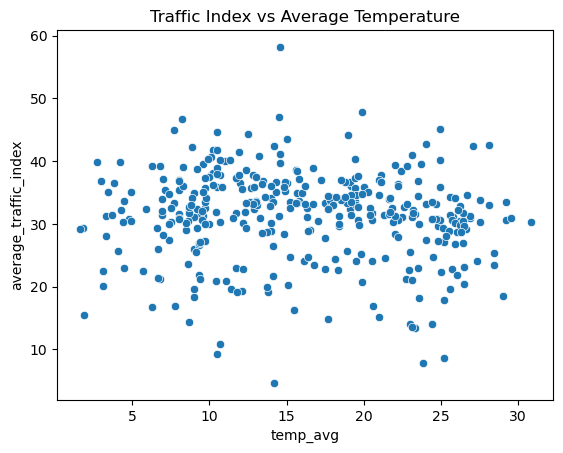

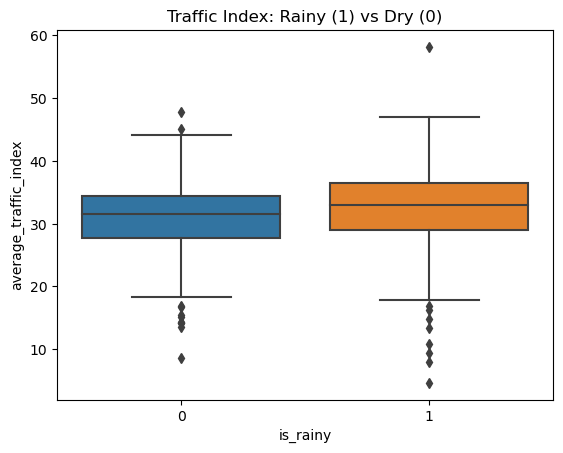

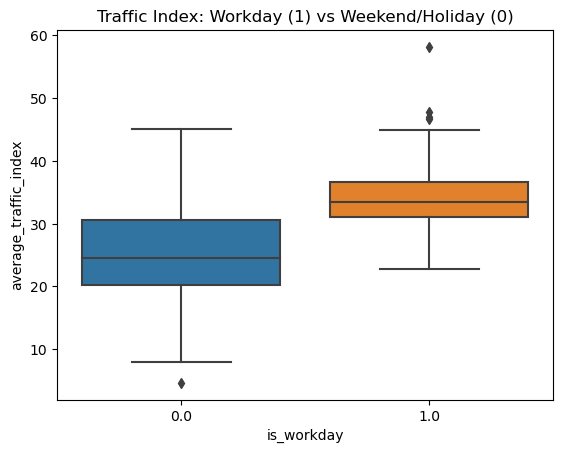

In [11]:

import matplotlib.pyplot as plt
import seaborn as sns

# traffic vs temperature
sns.scatterplot(data=df, x="temp_avg", y="average_traffic_index")
plt.title("Traffic Index vs Average Temperature")
plt.show()

# traffic on rainy vs dry days
df["is_rainy"] = (df["precipitation"] > 0).astype(int)
sns.boxplot(data=df, x="is_rainy", y="average_traffic_index")
plt.title("Traffic Index: Rainy (1) vs Dry (0)")
plt.show()

# traffic on workdays vs weekends/holidays
sns.boxplot(data=df, x="is_workday", y="average_traffic_index")
plt.title("Traffic Index: Workday (1) vs Weekend/Holiday (0)")
plt.show()


In [12]:
from scipy.stats import ttest_ind
import pandas as pd

df = pd.read_csv("istanbul_traffic_weather_2023.csv")

# binary rain indicator
df["is_rainy"] = (df["precipitation"] > 0).astype(int)

rainy = df[df["is_rainy"] == 1]["average_traffic_index"]
dry   = df[df["is_rainy"] == 0]["average_traffic_index"]

t_stat, p_val = ttest_ind(rainy, dry, equal_var=False, nan_policy="omit")

print("Rain vs Dry t-test")
print("t-statistic:", t_stat)
print("p-value:", p_val)


Rain vs Dry t-test
t-statistic: 1.446041830594893
p-value: 0.14907454286848537


In [13]:
from scipy.stats import ttest_ind
import pandas as pd

df = pd.read_csv("istanbul_traffic_weather_2023.csv")

workdays = df[df["is_workday"] == 1.0]["average_traffic_index"]
offdays  = df[df["is_workday"] == 0.0]["average_traffic_index"]

t_stat2, p_val2 = ttest_ind(workdays, offdays, equal_var=False, nan_policy="omit")

print("Workday vs Weekend/Holiday t-test")
print("t-statistic:", t_stat2)
print("p-value:", p_val2)


Workday vs Weekend/Holiday t-test
t-statistic: 11.499409613895953
p-value: 2.0346914158481092e-22


In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# -------------------------------------------------
# 1) VERİYİ YÜKLE
# -------------------------------------------------
df = pd.read_csv("istanbul_traffic_weather_2023.csv")

# yardimci degiskenler
df["is_rainy"] = (df["precipitation"] > 0).astype(int)

# -------------------------------------------------
# 2) T-TESTLERI TEKRAR HESAPLA (TITLE İÇİN)
# -------------------------------------------------
# Rain vs Dry
rainy = df[df["is_rainy"] == 1]["average_traffic_index"]
dry   = df[df["is_rainy"] == 0]["average_traffic_index"]

t_stat_rain, p_val_rain = ttest_ind(
    rainy, dry, equal_var=False, nan_policy="omit"
)

# Workday vs Weekend/Holiday
workdays = df[df["is_workday"] == 1.0]["average_traffic_index"]
offdays  = df[df["is_workday"] == 0.0]["average_traffic_index"]

t_stat_work, p_val_work = ttest_ind(
    workdays, offdays, equal_var=False, nan_policy="omit"
)

# -------------------------------------------------
# 3) SCREENSHOTS KLASÖRÜ OLUŞTUR
# -------------------------------------------------
os.makedirs("screenshots", exist_ok=True)

# -------------------------------------------------
# 4) RAIN vs DRY – BOXPLOT
# -------------------------------------------------
plt.figure(figsize=(6, 4))
df_rain_plot = df.copy()
df_rain_plot["Rainy"] = df_rain_plot["is_rainy"].map({0: "Dry (0)", 1: "Rainy (1)"})

plt.boxplot(
    [dry.dropna(), rainy.dropna()],
    labels=["Dry (0)", "Rainy (1)"]
)

plt.ylabel("Average Traffic Index")
plt.title(
    f"Traffic Index: Rainy vs Dry\n"
    f"t = {t_stat_rain:.2f}, p = {p_val_rain:.3f}"
)

plt.tight_layout()
plt.savefig("screenshots/rain_vs_dry_boxplot.png", dpi=300)
plt.close()

# -------------------------------------------------
# 5) WORKDAY vs WEEKEND/HOLIDAY – BOXPLOT
# -------------------------------------------------
plt.figure(figsize=(6, 4))

plt.boxplot(
    [offdays.dropna(), workdays.dropna()],
    labels=["Weekend/Holiday (0)", "Workday (1)"]
)

plt.ylabel("Average Traffic Index")
plt.title(
    f"Traffic Index: Workday vs Weekend/Holiday\n"
    f"t = {t_stat_work:.2f}, p = {p_val_work:.3e}"
)

plt.tight_layout()
plt.savefig("screenshots/workday_vs_offdays_boxplot.png", dpi=300)
plt.close()

# -------------------------------------------------
# 6) OPTIONAL: MEAN BARPLOT (GRUP ORTALAMALARI)
# -------------------------------------------------
# Mean traffic index for rain vs dry
mean_dry = dry.mean()
mean_rain = rainy.mean()

plt.figure(figsize=(6, 4))
plt.bar(["Dry (0)", "Rainy (1)"], [mean_dry, mean_rain])
plt.ylabel("Average Traffic Index (Mean)")
plt.title("Mean Traffic Index: Rainy vs Dry")
plt.tight_layout()
plt.savefig("screenshots/rain_vs_dry_mean_bar.png", dpi=300)
plt.close()

# Mean traffic index for workday vs offdays
mean_off = offdays.mean()
mean_work = workdays.mean()

plt.figure(figsize=(6, 4))
plt.bar(["Weekend/Holiday (0)", "Workday (1)"], [mean_off, mean_work])
plt.ylabel("Average Traffic Index (Mean)")
plt.title("Mean Traffic Index: Workday vs Weekend/Holiday")
plt.tight_layout()
plt.savefig("screenshots/workday_vs_offdays_mean_bar.png", dpi=300)
plt.close()

print("Grafikler 'screenshots/' klasörüne kaydedildi.")


Grafikler 'screenshots/' klasörüne kaydedildi.
